In [70]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DateType
from datetime import date, timedelta
import datetime as dt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import col, avg, sum
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
import pyspark

In [71]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.error("pyspark script logger initialized")

In [72]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [73]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)

In [77]:
cluster_feature = sqlcontext.read.csv(path=base_path+"k-means-8-feature_6days.csv",header=True,inferSchema=True)
cluster_feature = cluster_feature.drop("_c0","date2")
# cluster_feature = cluster_feature.withColumn("windSpeed",cluster_feature["windSpeed"].cast("float"))
# cluster_feature = cluster_feature.withColumn("dewPoint",cluster_feature["dewPoint"].cast("float"))
cluster_feature.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_2: double (nullable = true)
 |-- 4_diff_energy_

In [78]:
outputCols = ["weekDay_index","precipType_index","summary_index"]
df_encoded = cluster_feature
df_encoded = df_encoded.na.drop()
for col in outputCols: 
    encoder = OneHotEncoder(inputCol=col, outputCol="category_{}".format(col))
    df_encoded = encoder.transform(df_encoded).cache()
df_encoded = df_encoded.drop("rnk")
df_encoded.printSchema()


root
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_2: double (nullable = true)
 |-- 4_diff_energy_

In [79]:
#Remove 6 days feature
extra_feature = []
for lag_hour in range(0,3):
        for diff in range(3,7):
            extra_feature.append("{}_diff_energy_t_{}".format(diff,lag_hour))
for days in range(3,7):
        extra_feature.append("mean_{}".format(days))
        extra_feature.append("min_{}".format(days))
        extra_feature.append("max_{}".format(days)) 
inputCols = ["weekDay","precipType","summary",]
columns = df_encoded.columns
feature_col = columns[4:]
feature_col.append(columns[2])
feature_col = set(feature_col) - set(inputCols)
feature_col = feature_col - set(outputCols)
feature_col = feature_col - set(extra_feature)
feature_col = list(feature_col)
df_encoded = df_encoded.na.drop()
len(feature_col)

32

In [80]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(df_encoded)
df_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=181.633, month=1, weekDay='Tue', 1_diff_energy_t_0=163.88, 2_diff_energy_t_0=171.13, 3_diff_energy_t_0=169.788, 4_diff_energy_t_0=165.544, 5_diff_energy_t_0=158.319, 6_diff_energy_t_0=158.918, 1_diff_energy_t_1=187.865, 2_diff_energy_t_1=185.326, 3_diff_energy_t_1=187.275, 4_diff_energy_t_1=183.415, 5_diff_energy_t_1=166.311, 6_diff_energy_t_1=172.453, 1_diff_energy_t_2=224.507, 2_diff_energy_t_2=227.34, 3_diff_energy_t_2=221.904, 4_diff_energy_t_2=217.02, 5_diff_energy_t_2=207.147, 6_diff_energy_t_2=193.731, diff_energy_week_t_1=154.258, diff_energy_week_t_2=154.541, diff_energy_week_t_3=161.117, diff_energy_week_t_4=160.356, mean_1=181.54587500000002, mean_2=184.17049999999998, mean_3=183.41945833333332, mean_4=179.73729166666666, mean_5=176.49670833333334, mean_6=170.50029166666664, min_1=97.008, max_1=282.125, min_2=93.813, max_2=271.852, min_3=95.023, max_3=279.498, min_4=96.869, max_4=274.422, min_

In [81]:
df_feature = df_feature.withColumnRenamed("energy(kWh/h)","label")
df_feature = df_feature.withColumn("date",df_feature["date"].cast(DateType()))
df_feature.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_2: double (nullable = true)
 |-- 4_diff_energy_t_2: double (

##  actual and Predicted for given day

In [82]:
def get_aggregate(df):
    list = ["date","hour"]
    df = df.groupBy(list).agg(sum("label"),sum("prediction"))    
    return df

def select_predicted_actual(df,date,LCLid=None):
    list = []
    if LCLid != None:
        list = df.where((df["LCLid"] == LCLid) & (df["date"] == date)).select("label","prediction").collect()
    else:
        list = df.where((df["date"] == date)).select("label","prediction").collect()
    actual = [int(row['label']) for row in list]
    predicted = [int(row['prediction']) for row in list]
    return actual,predicted

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.abs((y_true - y_pred)**2)))

# Train-Test Split

In [108]:
train_df_cluster = []
test_df_cluster = []
num_of_cluster = 8
for cluster_id in range(num_of_cluster):
    train_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] <= date(2013,10,31)))
    test_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] > date(2013,10,31)))# & (df_feature["date"] <= date(2013,1,2)))
    print("Train_point = {}, Test_point = {}, cId = {}".format(train_df.count(),test_df.count(),cluster_id))
    train_df_cluster.append(train_df)
    test_df_cluster.append(test_df)

Train_point = 7288, Test_point = 1464, cId = 0
Train_point = 7288, Test_point = 1464, cId = 1
Train_point = 7288, Test_point = 1464, cId = 2
Train_point = 7288, Test_point = 1464, cId = 3
Train_point = 7288, Test_point = 1464, cId = 4
Train_point = 7288, Test_point = 1464, cId = 5
Train_point = 7288, Test_point = 1464, cId = 6
Train_point = 7288, Test_point = 1464, cId = 7


## Random Forest

In [102]:
pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    rf = RandomForestRegressor(numTrees=20,maxDepth=10,maxBins=128,seed=4)
    model = rf.fit(train_df_cluster[cluster_id])
    rf_pred_val = model.transform(test_df_cluster[cluster_id])
    if flag == 0:
        pred_val = sqlcontext.createDataFrame([],rf_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(rf_pred_val)
    pred_val = pred_val.cache()

## GBT

In [109]:
pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    gbt = GBTRegressor(maxBins=128,maxDepth=10)
    gbt_model = gbt.fit(train_df_cluster[cluster_id])
    gbt_pred_val = gbt_model.transform(test_df_cluster[cluster_id])
    if flag == 0:
        pred_val = sqlcontext.createDataFrame([],gbt_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(gbt_pred_val)
    pred_val = pred_val.cache()

In [110]:
aggregate_df = get_aggregate(pred_val)
aggregate_df = aggregate_df.withColumnRenamed("sum(label)","label")
aggregate_df = aggregate_df.withColumnRenamed("sum(prediction)","prediction")

In [111]:
train_start_date = date(2013,11,1)
train_end_date = date(2013,12,31)
y_date = []
Mape_date = []
rmse_date = []
while train_start_date <= train_end_date:
    print(train_start_date)
    y_actual,y_pred = select_predicted_actual(aggregate_df,train_start_date)
    if len(y_actual) == 0:
        train_start_date = train_start_date + timedelta(1)
        continue
    Mape_date.append(mean_absolute_percentage_error(y_actual,y_pred))
    rmse_date.append(root_mean_squared_error(y_actual,y_pred))
    y_date.append(train_start_date)
    train_start_date = train_start_date + timedelta(1)

2013-11-01
2013-11-02
2013-11-03
2013-11-04
2013-11-05
2013-11-06
2013-11-07
2013-11-08
2013-11-09
2013-11-10
2013-11-11
2013-11-12
2013-11-13
2013-11-14
2013-11-15
2013-11-16
2013-11-17
2013-11-18
2013-11-19
2013-11-20
2013-11-21
2013-11-22
2013-11-23
2013-11-24
2013-11-25
2013-11-26
2013-11-27
2013-11-28
2013-11-29
2013-11-30
2013-12-01
2013-12-02
2013-12-03
2013-12-04
2013-12-05
2013-12-06
2013-12-07
2013-12-08
2013-12-09
2013-12-10
2013-12-11
2013-12-12
2013-12-13
2013-12-14
2013-12-15
2013-12-16
2013-12-17
2013-12-18
2013-12-19
2013-12-20
2013-12-21
2013-12-22
2013-12-23
2013-12-24
2013-12-25
2013-12-26
2013-12-27
2013-12-28
2013-12-29
2013-12-30
2013-12-31


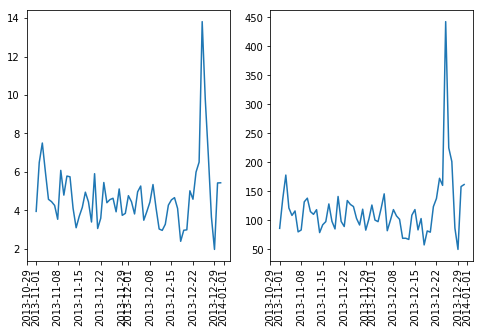

In [112]:
#del y_date[2]
# fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax1.xaxis.set_major_locator(mdates.DayLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax2.xaxis.set_major_locator(mdates.DayLocator())
# ax1.plot(y_date,Mape_date)
# ax2.plot(y_date,rmse_date)
# fig.autofmt_xdate()
# ax1.set_xlabel('k')
# ax1.set_ylabel('cost')
date_time = pd.to_datetime(y_date)
DF = pd.DataFrame()
DF['Mape_date'] = Mape_date
DF = DF.set_index(date_time)

DF1 = pd.DataFrame()
DF1['rmse_date'] = rmse_date
DF1 = DF1.set_index(date_time)
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
fig.subplots_adjust(bottom=0.3)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
ax1.plot(DF)
ax2.plot(DF1)

In [113]:
from statistics import mean
print("Mean RMSE = {}, Mean Mape = {}".format(mean(rmse_date),mean(Mape_date)))

Mean RMSE = 117.19859718698433, Mean Mape = 4.726183739860883


In [115]:
fig.savefig(base_path+"gbtf+k=8m_bin_128")

In [99]:
pred_val.where((pred_val.date==date(2013,12,25))).select("label","prediction").show(24)

+-------+------------------+
|  label|        prediction|
+-------+------------------+
|246.244|243.45621982602123|
|194.329|167.13812108913604|
|159.473|  135.594856655647|
|145.699| 143.8147083786912|
|139.278|140.84678930902444|
|134.022|131.50031144889869|
|140.768|144.77410255466648|
|195.227|  200.083466478445|
|286.266|217.34321408323402|
|359.943| 291.4283165386501|
|395.396|  279.195115118085|
|416.063|  282.133660286994|
|429.456|283.60592780568624|
|458.531|251.85421540346158|
|464.586|286.10400177335663|
|403.557|285.18188180237377|
|379.541| 337.3238469307507|
|389.032| 355.5829701432149|
| 383.01|439.23802009379705|
|364.894|440.08644042579226|
|358.508| 417.9906172071264|
|328.188| 354.2525618948277|
|307.703|342.72159915555875|
|271.645| 300.9610272853683|
+-------+------------------+
only showing top 24 rows



In [97]:
len(rmse_date)

61

In [100]:
y_date[54]

datetime.date(2013, 12, 25)